In [1]:
import pandas as pd
import torchaudio
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pipetorch.train import *
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import math
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import WeightedRandomSampler

using gpu 0


In [2]:
df = pd.read_csv('../nourish/res/dataset_tensors_melspec/train/audio_train_augmented_melspec_tensors.csv')
df

,filename,modification,label
0,-4wthmfwlwQ_260.pt,None,chewing
1,-5IpgOv9HD0_30.pt,None,chewing
2,-KO1p22zjVc_470.pt,None,chewing
3,-t-lmWNCXt0_10.pt,None,chewing
4,-t95P0R9Pf0_60.pt,None,chewing
...,...,...,...
7827,4gBf0FWwKnQ_100_squeezed.pt,squeezed,other
7828,4gBf0FWwKnQ_100_extended.pt,extended,other
7829,4gBf0FWwKnQ_100_shiftRight.pt,shiftRight,other
7830,4gBf0FWwKnQ_100_shiftLeft.pt,shiftLeft,other


In [3]:
class AudioSet(Dataset):
    def __init__(self, df, root_dir, in_col, out_col, length_sec, sampling_rate):
        self.df = df
        self.root_dir = root_dir
        self.in_col = in_col
        self.out_col = out_col
        self.length_sec = length_sec
        self.sampling_rate = sampling_rate
        
        self.c2i = {'chewing': 0, 'drinking': 0, 'other': 1}
        self.i2c = {0: 'chewing', 1: 'other'}
        
    def __getitem__(self, index):
        filepath = self.root_dir + self.df.iloc[index][self.in_col]
        data = torch.load(filepath)
        label = self.c2i[self.df.iloc[index][self.out_col]]
        return data.cuda(), label
        
    def __len__(self):
        return len(self.df)

In [4]:
def my_precision_score(true_y, pred_y):
    return precision_score(true_y, pred_y, average=None)

In [5]:
def my_recall_score(true_y, pred_y):
    return recall_score(true_y, pred_y, average=None)

In [6]:
def sort_epochs(results, by):
    results = results[results['phase'] != '']
    results[['prec_chewing', 'prec_other']] = pd.DataFrame(results['my_precision_score'].tolist(), index=results.index)
    results[['recall_chewing', 'recall_other']] = pd.DataFrame(results['my_recall_score'].tolist(), index=results.index)

    results = results[results['phase'] == 'valid']
    results = results.sort_values(by, ascending=False)
    print(results[['accuracy_score', 'epoch', 'prec_chewing', 'recall_chewing', 'recall_other']])

In [7]:

# thanks to https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
# modified the function a little to fit our needs

def make_confusion_matrix(true_y,
                          pred_y,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''
    
    cf = confusion_matrix(true_y, pred_y)
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [round(value / np.sum(cf[i // 3]) * 100, 2) for i, value in enumerate(cf.flatten())]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}%".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))


        #Metrics for Binary Confusion Matrices
        precision = precision_score(true_y, pred_y, average=None)
        
        stats_text = "\n\nAccuracy={:0.3f}\nPrecision Chewing/drinking={:0.3f}\n Precision other={:0.3f}\n".format(
            accuracy, precision[0], precision[1])
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False
    
    group_percentages = np.reshape(group_percentages, (2, 2))

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(
        group_percentages,annot=box_labels,
        fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,
        yticklabels=categories, vmin=0, vmax=100)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [8]:
c2i = {'chewing': 0, 'drinking': 0, 'other': 1}

def predict_test_set(model, df_test, audio_dir, print_wrong=True, gpu=True):
    model = model.cuda() if gpu else model.cpu()
    
    # get labels and filenames
    true_y = [c2i[label] for label in df_test['label'].values]
    filenames = df_test['filename'].values
    pred_y = []
    
    for filename in filenames:
        t = torch.load(audio_dir + filename)
        t = t.cuda() if gpu else t.cpu()
        t = t[None, :] # expand the tensor
        
        with torch.no_grad():
            pred = model(t)
            pred = model.post_forward(pred)
            pred_y.append(pred.data.cpu().numpy()[0])
    # plot conf matrix
    make_confusion_matrix(true_y, pred_y)
    plt.show()
    
    if print_wrong:
        # get false negatives and false positives of eating and drinking
        fn_eating_ind = []
        fn_drinking_ind = []
        fp_eating_ind = []
        fp_drinking_ind = []
        for i, y in enumerate(zip(true_y, pred_y)):
            if(y[0] != y[1]):
                # fn eating
                if y[0] == 0:
                    fn_eating_ind.append(i)
                
                # fn drinking
                if y[0] == 1:
                    fn_drinking_ind.append(i)
                
                # fp eating
                if y[1] == 0:
                    fp_eating_ind.append(i)
            
                # fp drinking
                if y[1] == 1:
                    fp_drinking_ind.append(i)
                
        fn_eating_filenames = [filenames[i] for i in fn_eating_ind]
        fn_drinking_filenames = [filenames[i] for i in fn_drinking_ind]
        fp_eating_filenames = [filenames[i] for i in fp_eating_ind]
        fp_drinking_filenames = [filenames[i] for i in fp_drinking_ind]
    
        # print it
        print('FALSE NEGATIVES EATING:', end='\n\t')
        print('\n\t'.join(fn_eating_filenames))
        print('FALSE NEGATIVES DRINKING:', end='\n\t')
        print('\n\t'.join(fn_drinking_filenames))
        print('FALSE POSITIVES EATING:', end='\n\t')
        print('\n\t'.join(fp_eating_filenames))
        print('FALSE POSITIVES DRINKING:', end='\n\t')
        print('\n\t'.join(fp_drinking_filenames))

In [9]:
df_pos = pd.concat([df[df['label']=='chewing'], df[df['label']=='drinking']])
df_neg = df.drop(df_pos.index)
bdf_neg = df_neg.sample(n=len(df_pos.index))
bdf = pd.concat([df_pos, bdf_neg])

In [10]:
df_valid = bdf.sample(n=int((len(bdf.index))/5))
df_train = bdf.drop(df_valid.index)
df_test = pd.read_csv('../nourish/res/dataset_tensors_melspec/test/audio_test_melspec_tensors.csv')
# shuffling the sets
df_valid = df_valid.sample(frac=1)
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)
df_train

,filename,modification,label
2780,C0jnh2o4Gj4_580_squeezed.pt,squeezed,chewing
2235,3LssvSirTQc_140_extended.pt,extended,chewing
417,drinks_6_11.pt,None,drinking
456,drinks_6_51.pt,None,drinking
1711,0MGzTdcPIPI_16.pt,None,other
...,...,...,...
952,-MF5vEZw19Q_130.pt,None,other
5094,drinks_6_42_background_sound.pt,background_sound,drinking
4320,drinks_3_03_squeezed.pt,squeezed,drinking
3175,KLnEV0O3nfo_400_shiftLeft.pt,shiftLeft,chewing


In [11]:
batch_size = 64

root_dir_train = '../nourish/res/dataset_tensors_melspec/train/audio/'
root_dir_test = '../nourish/res/dataset_tensors_melspec/test/audio/'
train_data = AudioSet(df_train, root_dir_train, 'filename', 'label', 10, 16000)
valid_data = AudioSet(df_valid, root_dir_train, 'filename', 'label', 10, 16000)
test_data = AudioSet(df_test, root_dir_test, 'filename', 'label', 10, 16000)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__(), shuffle=True)

lr = 0.001
epochs = 100

metrics = [accuracy_score, my_precision_score, my_recall_score]

# 1 conv 1 lin

In [61]:
class cnn1Layer1(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(self.out_channels*16*100 , 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = X.reshape(-1, self.out_channels*16*100)
        X = self.w1(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [62]:
cnn1_model = cnn1Layer1(4)
cnn1_trainer = trainer(cnn1_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn1_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/787200 [00:00<?, ?it/s]

  1 4.76s trainloss=210.54791 validloss=92.05612 accuracy_score=0.65921 
  2 4.69s trainloss=59.26558 validloss=84.19698 accuracy_score=0.66176 
  3 4.69s trainloss=36.42426 validloss=35.17392 accuracy_score=0.69693 
  4 4.69s trainloss=12.31715 validloss=27.83709 accuracy_score=0.68798 
  5 4.69s trainloss=7.74078 validloss=24.40428 accuracy_score=0.69757 
  6 4.71s trainloss=6.11801 validloss=26.28150 accuracy_score=0.69629 
  7 4.71s trainloss=5.68569 validloss=21.60367 accuracy_score=0.68862 
  8 4.70s trainloss=4.53864 validloss=18.93958 accuracy_score=0.70460 
  9 4.70s trainloss=2.96559 validloss=19.99244 accuracy_score=0.69246 
 10 4.71s trainloss=3.29187 validloss=17.13955 accuracy_score=0.69118 
 11 4.68s trainloss=2.92276 validloss=18.77422 accuracy_score=0.68798 
 12 4.68s trainloss=2.49388 validloss=15.14423 accuracy_score=0.70396 
 13 4.68s trainloss=2.52270 validloss=14.64806 accuracy_score=0.70652 
 14 4.68s trainloss=1.98344 validloss=15.33120 accuracy_score=0.69246 
 

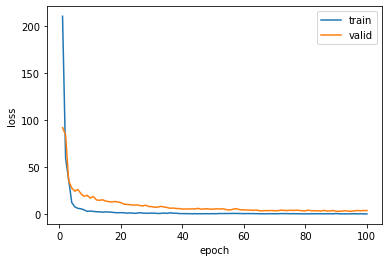

In [63]:
cnn1_trainer.learning_curve()

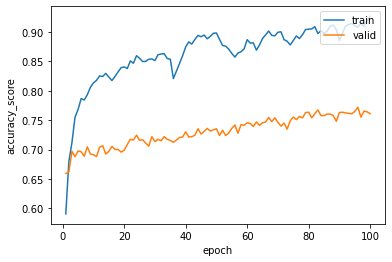

In [64]:
cnn1_trainer.learning_curve(y='accuracy_score')

In [65]:
sort_epochs(cnn1_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
191        0.771739   96.0      0.778870        0.781751      0.760956
165        0.767263   83.0      0.776267        0.774353      0.759628
195        0.765345   98.0      0.776119        0.769420      0.760956
189        0.764706   95.0      0.772448        0.774353      0.754316
197        0.764066   99.0      0.774876        0.768187      0.759628
..              ...    ...           ...             ...           ...
13         0.688619    7.0      0.728169        0.637485      0.743692
21         0.687980   11.0      0.723994        0.643650      0.735724
7          0.687980    4.0      0.716198        0.659679      0.718459
3          0.661765    2.0      0.667857        0.691739      0.629482
1          0.659207    1.0      0.681937        0.642417      0.677291

[100 rows x 5 columns]


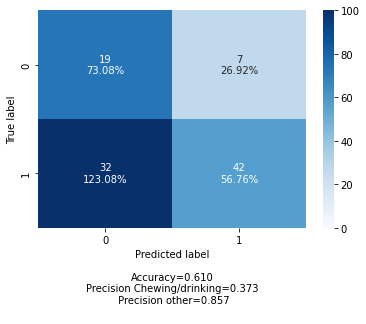

In [66]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn1_model = cnn1_model.cuda()

with torch.no_grad():
        pred_y = cnn1_model(test_X)
        pred_y = cnn1_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# 1 conv 2 lin

In [67]:
class cnn1Layer2(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(self.out_channels*16*100 , 100)
        self.w2 = nn.Linear(100, 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = X.reshape(-1, self.out_channels*16*100)
        X = self.w1(X)
        X = self.w2(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [68]:
cnn1_2_model = cnn1Layer2(4)
cnn1_2_trainer = trainer(cnn1_2_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn1_2_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/787200 [00:00<?, ?it/s]

  1 4.73s trainloss=272.05263 validloss=36.91045 accuracy_score=0.58248 
  2 4.69s trainloss=7.80520 validloss=3.87055 accuracy_score=0.64898 
  3 4.76s trainloss=4.01955 validloss=4.54080 accuracy_score=0.67008 
  4 4.77s trainloss=2.46853 validloss=2.71721 accuracy_score=0.67775 
  5 4.73s trainloss=1.96549 validloss=3.25088 accuracy_score=0.65026 
  6 4.73s trainloss=1.57892 validloss=2.00706 accuracy_score=0.64130 
  7 4.72s trainloss=4.53648 validloss=3.00530 accuracy_score=0.66688 
  8 4.74s trainloss=1.88910 validloss=2.58879 accuracy_score=0.65985 
  9 4.73s trainloss=8.94941 validloss=10.66978 accuracy_score=0.62788 
 10 4.73s trainloss=2.89838 validloss=7.74442 accuracy_score=0.67647 
 11 4.75s trainloss=1.74923 validloss=3.25168 accuracy_score=0.67327 
 12 4.73s trainloss=1.33122 validloss=3.15773 accuracy_score=0.68734 
 13 4.74s trainloss=4.09700 validloss=8.54300 accuracy_score=0.67775 
 14 4.74s trainloss=3.22715 validloss=8.96747 accuracy_score=0.68734 
 15 4.73s trainl

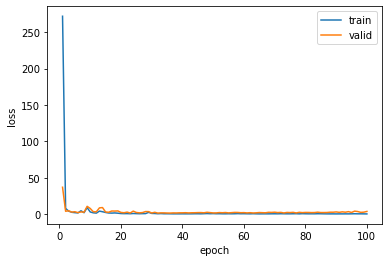

In [69]:
cnn1_2_trainer.learning_curve()

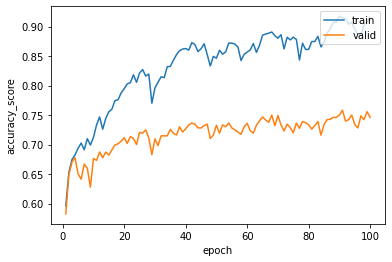

In [70]:
cnn1_2_trainer.learning_curve(y='accuracy_score')

In [71]:
sort_epochs(cnn1_2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
181        0.758312   91.0      0.756213        0.787916      0.726428
197        0.755754   99.0      0.765799        0.762022      0.749004
135        0.750000   68.0      0.767176        0.743527      0.756972
187        0.750000   94.0      0.758621        0.759556      0.739708
179        0.750000   90.0      0.748815        0.779285      0.718459
..              ...    ...           ...             ...           ...
9          0.650256    5.0      0.660976        0.668311      0.630810
3          0.648977    2.0      0.668814        0.639951      0.658699
11         0.641304    6.0      0.624008        0.775586      0.496680
17         0.627877    9.0      0.609360        0.786683      0.456839
1          0.582481    1.0      0.578218        0.720099      0.434263

[100 rows x 5 columns]


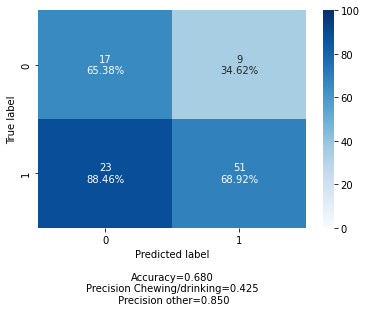

In [72]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn1_2_model = cnn1_2_model.cuda()

with torch.no_grad():
        pred_y = cnn1_2_model(test_X)
        pred_y = cnn1_2_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# 2conv1lin

In [73]:
class cnn2Layer1(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(self.out_channels, 2*self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(2*self.out_channels*8*50 , 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = self.layer2(X)
        X = X.reshape(-1, 2*self.out_channels*8*50)
        X = self.w1(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [74]:
cnn2_model = cnn2Layer1(4)
cnn2_trainer = trainer(cnn2_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn2_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/787200 [00:00<?, ?it/s]

  1 4.89s trainloss=43.26799 validloss=13.24805 accuracy_score=0.67072 
  2 4.88s trainloss=7.13242 validloss=6.33930 accuracy_score=0.69246 
  3 4.86s trainloss=3.51315 validloss=3.40861 accuracy_score=0.69118 
  4 4.90s trainloss=1.86397 validloss=2.71167 accuracy_score=0.71228 
  5 4.98s trainloss=1.26181 validloss=2.22945 accuracy_score=0.73657 
  6 4.87s trainloss=0.89921 validloss=2.04808 accuracy_score=0.73146 
  7 4.87s trainloss=0.70851 validloss=1.88529 accuracy_score=0.73977 
  8 4.89s trainloss=0.68678 validloss=1.73987 accuracy_score=0.74616 
  9 4.96s trainloss=0.53380 validloss=1.55491 accuracy_score=0.75256 
 10 4.93s trainloss=0.49434 validloss=1.57614 accuracy_score=0.75256 
 11 4.89s trainloss=0.45606 validloss=1.58732 accuracy_score=0.75895 
 12 4.88s trainloss=0.46764 validloss=1.57600 accuracy_score=0.75320 
 13 4.91s trainloss=0.42690 validloss=1.46062 accuracy_score=0.76023 
 14 4.92s trainloss=0.40997 validloss=1.47594 accuracy_score=0.76471 
 15 4.91s trainlos

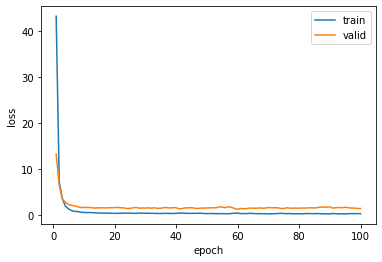

In [75]:
cnn2_trainer.learning_curve()

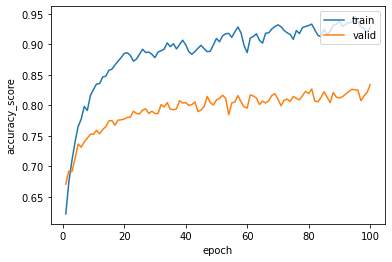

In [76]:
cnn2_trainer.learning_curve(y='accuracy_score')

In [77]:
sort_epochs(cnn2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
199        0.833760  100.0      0.819235        0.871763      0.792829
161        0.826726   81.0      0.840050        0.822441      0.831341
187        0.826087   94.0      0.828258        0.838471      0.812749
189        0.825448   95.0      0.834577        0.827374      0.823373
191        0.824808   96.0      0.851900        0.801480      0.849934
..              ...    ...           ...             ...           ...
11         0.731458    6.0      0.733572        0.757090      0.703851
7          0.712276    4.0      0.689005        0.811344      0.605578
3          0.692455    2.0      0.697842        0.717633      0.665339
5          0.691176    3.0      0.672996        0.786683      0.588313
1          0.670716    1.0      0.706128        0.625154      0.719788

[100 rows x 5 columns]


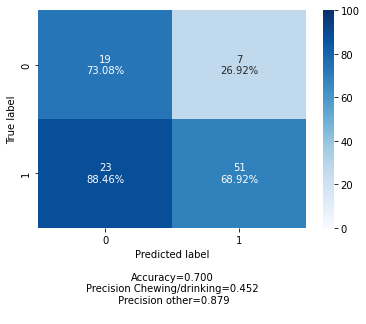

In [78]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn2_model = cnn2_model.cuda()

with torch.no_grad():
        pred_y = cnn2_model(test_X)
        pred_y = cnn2_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# 2conv2lin

In [79]:
class cnn2Layer2(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(self.out_channels, 2*self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(2*self.out_channels*8*50 , 100)
        self.w2 = nn.Linear(100, 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = self.layer2(X)
        X = X.reshape(-1, 2*self.out_channels*8*50)
        X = self.w1(X)
        X = self.w2(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [80]:
cnn2_2_model = cnn2Layer2(4)
cnn2_2_trainer = trainer(cnn2_2_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn2_2_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/787200 [00:00<?, ?it/s]

  1 4.99s trainloss=51.11215 validloss=5.26414 accuracy_score=0.66944 
  2 4.89s trainloss=2.98606 validloss=3.20486 accuracy_score=0.70141 
  3 4.94s trainloss=1.40108 validloss=1.94607 accuracy_score=0.71292 
  4 4.92s trainloss=0.77041 validloss=1.67328 accuracy_score=0.71611 
  5 4.87s trainloss=0.63347 validloss=1.62421 accuracy_score=0.70972 
  6 4.87s trainloss=0.58659 validloss=1.41302 accuracy_score=0.72698 
  7 4.86s trainloss=0.50963 validloss=1.30448 accuracy_score=0.72570 
  8 4.84s trainloss=0.46110 validloss=1.23997 accuracy_score=0.72826 
  9 4.86s trainloss=0.44775 validloss=1.30006 accuracy_score=0.72890 
 10 4.88s trainloss=0.46147 validloss=1.23011 accuracy_score=0.72251 
 11 4.89s trainloss=0.44620 validloss=1.18249 accuracy_score=0.72442 
 12 4.94s trainloss=0.44635 validloss=1.33468 accuracy_score=0.70844 
 13 4.89s trainloss=0.45398 validloss=1.34543 accuracy_score=0.72187 
 14 4.85s trainloss=0.44822 validloss=1.16163 accuracy_score=0.72698 
 15 4.88s trainloss

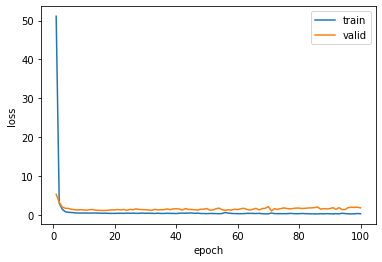

In [81]:
cnn2_2_trainer.learning_curve()

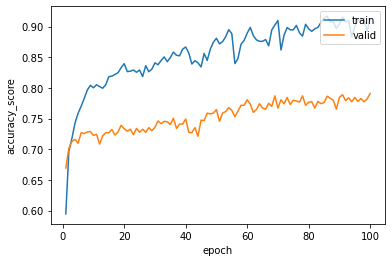

In [82]:
cnn2_2_trainer.learning_curve(y='accuracy_score')

In [83]:
sort_epochs(cnn2_2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
199        0.790921  100.0      0.789474        0.813810      0.766268
181        0.789003   91.0      0.792935        0.802713      0.774236
155        0.787084   78.0      0.803299        0.780518      0.794157
137        0.787084   69.0      0.783175        0.815043      0.756972
171        0.786445   86.0      0.786315        0.807645      0.763612
..              ...    ...           ...             ...           ...
5          0.712916    3.0      0.735065        0.697904      0.729084
9          0.709719    5.0      0.712753        0.737361      0.679947
23         0.708440   12.0      0.674533        0.845869      0.560425
3          0.701407    2.0      0.734332        0.664612      0.741036
1          0.669437    1.0      0.722054        0.589396      0.755644

[100 rows x 5 columns]


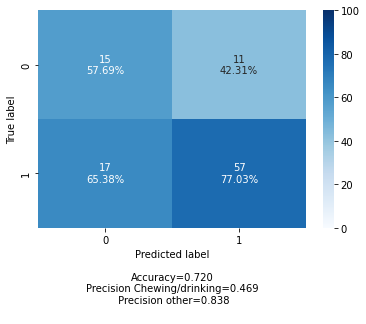

In [84]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn2_2_model = cnn2_2_model.cuda()

with torch.no_grad():
        pred_y = cnn2_2_model(test_X)
        pred_y = cnn2_2_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# ResNet

In [12]:
# nSamples = [1696, 2216, 3920] #of class instances
nSamples = [1696 + 2216, 3920] #of class instances
normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights).cuda()

In [13]:
def post_forward(y):
    return torch.argmax(y, axis=1)

# resnet 18

In [87]:
rn18 = models.resnet18(pretrained=True)
rn18.conv1 = nn.Conv2d(1, rn18.conv1.out_channels,
              kernel_size=rn18.conv1.kernel_size[0], 
                      stride=rn18.conv1.stride[0], 
                      padding=rn18.conv1.padding[0])
num_ftrs = rn18.fc.in_features
rn18.fc = nn.Linear(num_ftrs, 2)

rn18.post_forward = post_forward

rn18_trainer = trainer(rn18, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [88]:
rn18_trainer.train(100, lr=0.01, weight_decay=0.8)

Total:   0%|          | 0/787200 [00:00<?, ?it/s]

  1 7.10s trainloss=0.81615 validloss=0.69267 accuracy_score=0.55435 
  2 7.32s trainloss=0.66955 validloss=0.72730 accuracy_score=0.47762 
  3 7.21s trainloss=0.64754 validloss=64.14996 accuracy_score=0.52366 
  4 7.36s trainloss=0.67224 validloss=0.70263 accuracy_score=0.57992 
  5 7.26s trainloss=0.66548 validloss=0.70912 accuracy_score=0.48274 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  6 8.01s trainloss=0.66433 validloss=0.71710 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  7 8.33s trainloss=0.66002 validloss=0.73656 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  8 8.05s trainloss=0.65911 validloss=1.36182 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  9 8.10s trainloss=0.66372 validloss=0.71472 accuracy_score=0.48146 
 10 8.26s trainloss=0.65660 validloss=0.90475 accuracy_score=0.39962 
 11 7.97s trainloss=0.66997 validloss=0.80449 accuracy_score=0.52941 
 12 8.36s trainloss=0.65115 validloss=1.15244 accuracy_score=0.52366 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 13 7.97s trainloss=0.65674 validloss=0.72771 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 14 8.04s trainloss=0.65707 validloss=0.72203 accuracy_score=0.48146 
 15 8.08s trainloss=0.65819 validloss=0.94708 accuracy_score=0.55691 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 16 8.20s trainloss=0.66057 validloss=0.82691 accuracy_score=0.48146 
 17 8.38s trainloss=0.65478 validloss=1.00196 accuracy_score=0.45716 
 18 10.65s trainloss=0.67903 validloss=0.69348 accuracy_score=0.51535 
 19 11.07s trainloss=0.68848 validloss=0.71026 accuracy_score=0.47251 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 20 10.60s trainloss=0.67760 validloss=1.08702 accuracy_score=0.48146 
 21 10.71s trainloss=0.66390 validloss=0.69937 accuracy_score=0.55307 
 22 10.68s trainloss=0.65519 validloss=0.73588 accuracy_score=0.57737 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 23 10.65s trainloss=0.65196 validloss=0.85270 accuracy_score=0.48146 
 24 10.11s trainloss=0.65738 validloss=0.67399 accuracy_score=0.59527 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 25 10.45s trainloss=0.69343 validloss=0.69424 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 26 10.63s trainloss=0.69339 validloss=0.69416 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 27 10.49s trainloss=0.69338 validloss=0.69310 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 28 10.76s trainloss=0.69325 validloss=0.69361 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 29 10.30s trainloss=0.69334 validloss=0.69336 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 30 9.96s trainloss=0.69346 validloss=0.69265 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 31 10.72s trainloss=0.69342 validloss=0.69441 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 32 12.59s trainloss=0.69361 validloss=0.69311 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 33 11.08s trainloss=0.69364 validloss=0.69388 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 34 11.65s trainloss=0.69363 validloss=0.69514 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 35 7.90s trainloss=0.69366 validloss=0.69474 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 36 7.04s trainloss=0.69330 validloss=0.69367 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 37 6.98s trainloss=0.69337 validloss=0.69363 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 38 7.01s trainloss=0.69337 validloss=0.69465 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 39 7.09s trainloss=0.69321 validloss=0.69265 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 40 7.54s trainloss=0.69334 validloss=0.69282 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 41 7.31s trainloss=0.69319 validloss=0.69244 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 42 7.26s trainloss=0.69336 validloss=0.69272 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 43 7.47s trainloss=0.69375 validloss=0.69392 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 44 7.09s trainloss=0.69332 validloss=0.69305 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 45 7.16s trainloss=0.69338 validloss=0.69576 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 46 7.40s trainloss=0.69348 validloss=0.69284 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 47 7.36s trainloss=0.69333 validloss=0.69329 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 48 7.06s trainloss=0.69339 validloss=0.69297 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 49 7.18s trainloss=0.69319 validloss=0.69243 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 50 7.64s trainloss=0.69333 validloss=0.69331 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 51 7.05s trainloss=0.69327 validloss=0.69263 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 52 7.15s trainloss=0.69326 validloss=0.69398 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 53 6.99s trainloss=0.69312 validloss=0.69267 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 54 7.26s trainloss=0.69328 validloss=0.69248 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 55 7.25s trainloss=0.69350 validloss=0.69340 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 56 7.11s trainloss=0.69326 validloss=0.69477 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 57 7.50s trainloss=0.69337 validloss=0.69482 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 58 7.46s trainloss=0.69361 validloss=0.69351 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 59 7.03s trainloss=0.69326 validloss=0.69454 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 60 7.18s trainloss=0.69336 validloss=0.69430 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 61 6.97s trainloss=0.69365 validloss=0.69380 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 62 6.92s trainloss=0.69332 validloss=0.69246 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 63 7.26s trainloss=0.69363 validloss=0.69267 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 64 6.94s trainloss=0.69355 validloss=0.69321 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 65 6.99s trainloss=0.69342 validloss=0.69248 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 66 7.22s trainloss=0.69345 validloss=0.69396 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 67 7.24s trainloss=0.69302 validloss=0.69260 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 68 7.05s trainloss=0.69366 validloss=0.69384 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 69 7.25s trainloss=0.69347 validloss=0.69308 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 70 7.43s trainloss=0.69368 validloss=0.69311 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 71 6.90s trainloss=0.69330 validloss=0.69343 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 72 7.03s trainloss=0.69346 validloss=0.69419 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 73 7.04s trainloss=0.69332 validloss=0.69424 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 74 7.15s trainloss=0.69358 validloss=0.69254 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 75 7.02s trainloss=0.69364 validloss=0.69492 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 76 6.98s trainloss=0.69377 validloss=0.69313 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 77 7.25s trainloss=0.69346 validloss=0.69362 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 78 7.32s trainloss=0.69331 validloss=0.69376 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 79 7.63s trainloss=0.69351 validloss=0.69356 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 80 6.99s trainloss=0.69322 validloss=0.69546 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 81 6.98s trainloss=0.69347 validloss=0.69261 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 82 7.58s trainloss=0.69364 validloss=0.69610 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 83 7.86s trainloss=0.69360 validloss=0.69293 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 84 7.92s trainloss=0.69349 validloss=0.69433 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 85 7.92s trainloss=0.69309 validloss=0.69507 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 86 7.98s trainloss=0.69334 validloss=0.69510 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 87 7.81s trainloss=0.69349 validloss=0.69271 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 88 7.83s trainloss=0.69350 validloss=0.69379 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 89 7.91s trainloss=0.69309 validloss=0.69243 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 90 7.84s trainloss=0.69328 validloss=0.69487 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 91 7.84s trainloss=0.69319 validloss=0.69247 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 92 7.85s trainloss=0.69347 validloss=0.69285 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 93 7.85s trainloss=0.69352 validloss=0.69306 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 94 7.86s trainloss=0.69334 validloss=0.69256 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 95 7.86s trainloss=0.69342 validloss=0.69281 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 96 7.85s trainloss=0.69378 validloss=0.69355 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 97 7.85s trainloss=0.69343 validloss=0.69455 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 98 7.85s trainloss=0.69351 validloss=0.69357 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 99 7.19s trainloss=0.69326 validloss=0.69303 accuracy_score=0.51854 
100 6.93s trainloss=0.69330 validloss=0.69267 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


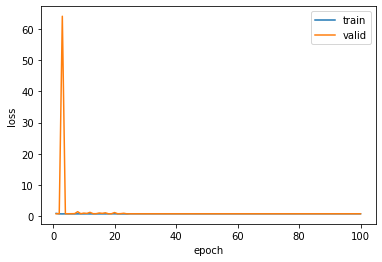

In [89]:
rn18_trainer.learning_curve()

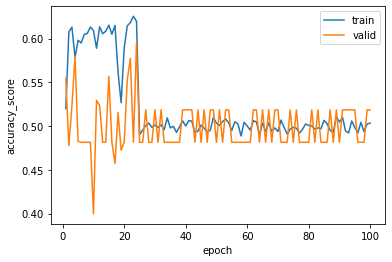

In [90]:
rn18_trainer.learning_curve(y='accuracy_score')

In [91]:
sort_epochs(rn18_trainer.evaluator, 'accuracy_score')

    accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
47        0.595269   24.0      0.702273        0.381011      0.826029
7         0.579923    4.0      0.570255        0.770654      0.374502
43        0.577366   22.0      0.562500        0.832306      0.302789
29        0.556905   15.0      0.545107        0.879162      0.209827
1         0.554348    1.0      0.543116        0.885327      0.197875
..             ...    ...           ...             ...           ...
39        0.481458   20.0      0.000000        0.000000      1.000000
3         0.477621    2.0      0.000000        0.000000      0.992032
37        0.472506   19.0      0.250000        0.008631      0.972112
33        0.457161   17.0      0.392045        0.085080      0.857902
19        0.399616   10.0      0.399687        0.314427      0.491368

[100 rows x 5 columns]


# resnet 34

In [92]:
rn34 = models.resnet34(pretrained=True)
rn34.conv1 = nn.Conv2d(1, rn34.conv1.out_channels,
              kernel_size=rn34.conv1.kernel_size[0], 
                      stride=rn34.conv1.stride[0], 
                      padding=rn34.conv1.padding[0])
num_ftrs = rn34.fc.in_features
rn34.fc = nn.Linear(num_ftrs, 2)

rn34.post_forward = post_forward

rn34_trainer = trainer(rn18, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [93]:
rn34_trainer.train(100, lr=0.01, weight_decay=0.5)

Total:   0%|          | 0/787200 [00:00<?, ?it/s]

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  1 7.34s trainloss=0.69359 validloss=0.69301 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  2 6.73s trainloss=0.69342 validloss=0.69304 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  3 6.75s trainloss=0.69333 validloss=0.69395 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  4 6.77s trainloss=0.69343 validloss=0.69424 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  5 7.36s trainloss=0.69344 validloss=0.69454 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  6 7.76s trainloss=0.69335 validloss=0.69293 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  7 7.73s trainloss=0.69358 validloss=0.69533 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  8 7.75s trainloss=0.69344 validloss=0.69339 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  9 7.77s trainloss=0.69328 validloss=0.69359 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 10 7.77s trainloss=0.69380 validloss=0.69330 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 11 7.87s trainloss=0.69312 validloss=0.69575 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 12 7.83s trainloss=0.69342 validloss=0.69547 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 13 7.82s trainloss=0.69405 validloss=0.69434 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 14 7.82s trainloss=0.69357 validloss=0.69501 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 15 7.96s trainloss=0.69348 validloss=0.69541 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 16 7.97s trainloss=0.69359 validloss=0.69394 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 17 8.02s trainloss=0.69359 validloss=0.69486 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 18 7.35s trainloss=0.69336 validloss=0.69433 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 19 6.85s trainloss=0.69342 validloss=0.69500 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 20 6.85s trainloss=0.69327 validloss=0.69409 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 21 6.87s trainloss=0.69349 validloss=0.69269 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 22 7.18s trainloss=0.69313 validloss=0.69772 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 23 6.96s trainloss=0.69325 validloss=0.69470 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 24 6.89s trainloss=0.69344 validloss=0.69309 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 25 6.89s trainloss=0.69349 validloss=0.69370 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 26 7.29s trainloss=0.69349 validloss=0.69388 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 27 6.85s trainloss=0.69345 validloss=0.69313 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 28 6.75s trainloss=0.69352 validloss=0.69458 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 29 7.10s trainloss=0.69345 validloss=0.69425 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 30 6.81s trainloss=0.69339 validloss=0.69500 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 31 6.86s trainloss=0.69328 validloss=0.69277 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 32 8.02s trainloss=0.69341 validloss=0.69397 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 33 7.98s trainloss=0.69359 validloss=0.69421 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 34 8.00s trainloss=0.69339 validloss=0.69357 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 35 8.42s trainloss=0.69325 validloss=0.69730 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 36 8.13s trainloss=0.69343 validloss=0.69500 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 37 8.27s trainloss=0.69360 validloss=0.69380 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 38 8.37s trainloss=0.69333 validloss=0.69300 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 39 8.17s trainloss=0.69361 validloss=0.69411 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 40 8.38s trainloss=0.69324 validloss=0.69288 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 41 8.37s trainloss=0.69336 validloss=0.69315 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 42 8.02s trainloss=0.69333 validloss=0.69327 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 43 8.21s trainloss=0.69356 validloss=0.69279 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 44 8.00s trainloss=0.69346 validloss=0.69257 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 45 8.50s trainloss=0.69334 validloss=0.69339 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 46 8.44s trainloss=0.69324 validloss=0.69538 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 47 8.41s trainloss=0.69370 validloss=0.69281 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 48 8.46s trainloss=0.69351 validloss=0.69294 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 49 8.42s trainloss=0.69340 validloss=0.69303 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 50 7.96s trainloss=0.69341 validloss=0.69342 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 51 8.04s trainloss=0.69367 validloss=0.69487 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 52 8.15s trainloss=0.69356 validloss=0.69460 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 53 8.18s trainloss=0.69352 validloss=0.69455 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 54 8.17s trainloss=0.69360 validloss=0.69243 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 55 7.53s trainloss=0.69370 validloss=0.69371 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 56 7.23s trainloss=0.69338 validloss=0.69258 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 57 6.95s trainloss=0.69344 validloss=0.69305 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 58 7.34s trainloss=0.69324 validloss=0.69417 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 59 7.12s trainloss=0.69366 validloss=0.69350 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 60 7.13s trainloss=0.69363 validloss=0.69422 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 61 8.03s trainloss=0.69375 validloss=0.69393 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 62 8.78s trainloss=0.69331 validloss=0.69423 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 63 9.06s trainloss=0.69334 validloss=0.69365 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 64 9.11s trainloss=0.69357 validloss=0.69379 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 65 8.81s trainloss=0.69354 validloss=0.69498 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 66 9.08s trainloss=0.69338 validloss=0.69264 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 67 9.05s trainloss=0.69331 validloss=0.69442 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 68 8.94s trainloss=0.69359 validloss=0.69301 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 69 8.92s trainloss=0.69352 validloss=0.69316 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 70 8.92s trainloss=0.69340 validloss=0.69278 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 71 8.83s trainloss=0.69338 validloss=0.69426 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 72 8.57s trainloss=0.69320 validloss=0.69285 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 73 8.16s trainloss=0.69324 validloss=0.69388 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 74 7.99s trainloss=0.69365 validloss=0.69423 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 75 8.11s trainloss=0.69347 validloss=0.69358 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 76 7.55s trainloss=0.69317 validloss=0.69268 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 77 7.08s trainloss=0.69359 validloss=0.69291 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 78 7.26s trainloss=0.69318 validloss=0.69708 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 79 6.95s trainloss=0.69331 validloss=0.69378 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 80 7.18s trainloss=0.69303 validloss=0.69812 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 81 7.10s trainloss=0.69365 validloss=0.69346 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 82 7.44s trainloss=0.69355 validloss=0.69446 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 83 7.33s trainloss=0.69325 validloss=0.69251 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 84 6.99s trainloss=0.69342 validloss=0.69360 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 85 7.36s trainloss=0.69342 validloss=0.69476 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 86 7.46s trainloss=0.69342 validloss=0.69314 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 87 6.92s trainloss=0.69329 validloss=0.69587 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 88 6.91s trainloss=0.69329 validloss=0.69477 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 89 7.43s trainloss=0.69368 validloss=0.69300 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 90 6.97s trainloss=0.69345 validloss=0.69413 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 91 6.98s trainloss=0.69329 validloss=0.69306 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 92 7.29s trainloss=0.69362 validloss=0.69505 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 93 6.96s trainloss=0.69349 validloss=0.69317 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 94 7.33s trainloss=0.69333 validloss=0.69376 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 95 8.15s trainloss=0.69367 validloss=0.69385 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 96 8.37s trainloss=0.69344 validloss=0.69352 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 97 8.16s trainloss=0.69356 validloss=0.69283 accuracy_score=0.51854 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 98 8.18s trainloss=0.69333 validloss=0.69368 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 99 8.16s trainloss=0.69338 validloss=0.69306 accuracy_score=0.51854 
100 8.36s trainloss=0.69308 validloss=0.69600 accuracy_score=0.48146 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


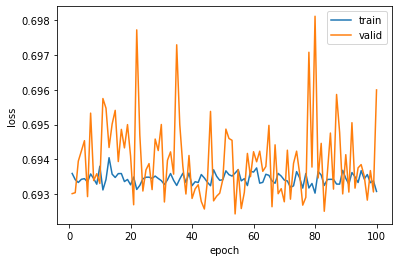

In [94]:
rn34_trainer.learning_curve()

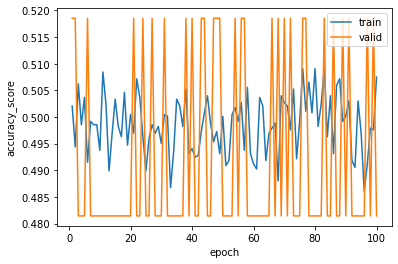

In [95]:
rn34_trainer.learning_curve(y='accuracy_score')

In [96]:
sort_epochs(rn34_trainer.evalutator, 'accuracy_score')

AttributeError: 'trainer' object has no attribute 'evalutator'

# resnet 152

In [14]:
rn_152 = models.resnet152(pretrained=True)

rn_152.conv1 = nn.Conv2d(1, rn_152.conv1.out_channels,
              kernel_size=rn_152.conv1.kernel_size[0], 
                      stride=rn_152.conv1.stride[0], 
                      padding=rn_152.conv1.padding[0])
num_ftrs = rn_152.fc.in_features
rn_152.fc = nn.Linear(num_ftrs, 2)

rn_152.post_forward = post_forward

rn_152_trainer = trainer(rn_152, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [15]:
rn_152_trainer.train(100, lr=0.01, weight_decay=0.2)

Total:   0%|          | 0/787200 [00:00<?, ?it/s]

  1 32.87s trainloss=0.82558 validloss=0.64676 accuracy_score=0.64514 
  2 19.83s trainloss=0.68258 validloss=0.75033 accuracy_score=0.50192 
  3 19.85s trainloss=0.68339 validloss=0.83227 accuracy_score=0.49425 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  4 19.87s trainloss=0.66810 validloss=0.69792 accuracy_score=0.50895 
  5 20.26s trainloss=0.66411 validloss=0.65010 accuracy_score=0.66176 
  6 19.96s trainloss=0.68524 validloss=0.69349 accuracy_score=0.54795 
  7 19.96s trainloss=0.66257 validloss=9.94881 accuracy_score=0.56586 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  8 19.94s trainloss=0.65146 validloss=1.02319 accuracy_score=0.50895 
  9 19.96s trainloss=0.67656 validloss=0.69667 accuracy_score=0.50767 
 10 19.95s trainloss=0.65344 validloss=0.73030 accuracy_score=0.50192 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 11 19.95s trainloss=0.65697 validloss=1.19256 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 12 19.96s trainloss=0.64661 validloss=0.75619 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 13 19.95s trainloss=0.67125 validloss=0.88008 accuracy_score=0.50895 
 14 20.06s trainloss=0.66404 validloss=0.73226 accuracy_score=0.45908 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 15 19.93s trainloss=0.66361 validloss=1.30245 accuracy_score=0.50895 
 16 19.91s trainloss=0.64139 validloss=1.26279 accuracy_score=0.55051 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 17 19.91s trainloss=0.67648 validloss=0.69572 accuracy_score=0.49105 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 18 19.92s trainloss=0.67547 validloss=0.68819 accuracy_score=0.50895 
 19 19.93s trainloss=0.69051 validloss=0.75630 accuracy_score=0.50256 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 20 19.94s trainloss=0.68734 validloss=0.72441 accuracy_score=0.50895 
 21 19.94s trainloss=0.67158 validloss=0.69023 accuracy_score=0.49744 
 22 19.93s trainloss=0.68137 validloss=0.71733 accuracy_score=0.57609 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 23 19.92s trainloss=0.66185 validloss=0.68270 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 24 19.92s trainloss=0.64586 validloss=0.67386 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 25 19.89s trainloss=0.67345 validloss=0.69824 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 26 19.89s trainloss=0.64526 validloss=0.71589 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 27 19.98s trainloss=0.65030 validloss=0.70247 accuracy_score=0.50895 
 28 19.86s trainloss=0.63318 validloss=49.31572 accuracy_score=0.59719 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 29 19.88s trainloss=0.63299 validloss=1.13499 accuracy_score=0.50895 
 30 19.88s trainloss=0.66579 validloss=1.17009 accuracy_score=0.50767 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 31 19.87s trainloss=0.67119 validloss=0.76903 accuracy_score=0.50895 
 32 19.88s trainloss=0.66078 validloss=0.63913 accuracy_score=0.65026 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 33 19.88s trainloss=0.65700 validloss=0.69485 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 34 19.88s trainloss=0.66631 validloss=0.71110 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 35 19.87s trainloss=0.66170 validloss=0.73029 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 36 19.85s trainloss=0.64965 validloss=0.70150 accuracy_score=0.50895 
 37 19.89s trainloss=0.67500 validloss=0.65719 accuracy_score=0.61829 
 38 19.87s trainloss=0.64859 validloss=0.69183 accuracy_score=0.50703 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 39 19.89s trainloss=0.66963 validloss=0.90252 accuracy_score=0.50895 
 40 19.98s trainloss=0.65916 validloss=0.69112 accuracy_score=0.51790 
 41 19.88s trainloss=0.63971 validloss=0.73683 accuracy_score=0.50703 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 42 19.86s trainloss=0.64852 validloss=0.69250 accuracy_score=0.50895 
 43 19.93s trainloss=0.64430 validloss=1.27002 accuracy_score=0.49105 
 44 19.89s trainloss=0.63810 validloss=0.75227 accuracy_score=0.63043 
 45 19.91s trainloss=0.63084 validloss=0.69314 accuracy_score=0.50831 
 46 19.89s trainloss=0.63564 validloss=0.69367 accuracy_score=0.49169 
 47 19.88s trainloss=0.65424 validloss=0.69309 accuracy_score=0.50192 
 48 19.89s trainloss=0.64668 validloss=1.70180 accuracy_score=0.60806 
 49 19.90s trainloss=0.64851 validloss=3.79606 accuracy_score=0.55243 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 50 19.90s trainloss=0.63388 validloss=0.70344 accuracy_score=0.50895 
 51 19.87s trainloss=0.64242 validloss=0.86610 accuracy_score=0.62020 
 52 19.87s trainloss=0.63193 validloss=0.73868 accuracy_score=0.47826 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 53 19.96s trainloss=0.64305 validloss=1.63369 accuracy_score=0.50895 
 54 19.93s trainloss=0.68947 validloss=0.72501 accuracy_score=0.50895 
 55 19.88s trainloss=0.67638 validloss=0.66123 accuracy_score=0.64386 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 56 19.89s trainloss=0.65856 validloss=0.77363 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 57 19.88s trainloss=0.66942 validloss=0.90599 accuracy_score=0.49105 
 58 19.88s trainloss=0.65339 validloss=0.86450 accuracy_score=0.64066 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 59 19.89s trainloss=0.68064 validloss=4.89305 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 60 19.88s trainloss=0.68168 validloss=0.76580 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 61 19.91s trainloss=0.66061 validloss=1.16840 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 62 19.91s trainloss=0.66532 validloss=0.72785 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 63 19.91s trainloss=0.65794 validloss=0.69455 accuracy_score=0.49105 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 64 19.88s trainloss=0.65340 validloss=0.74227 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 65 19.89s trainloss=0.67531 validloss=0.70480 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 66 19.99s trainloss=0.66230 validloss=0.77579 accuracy_score=0.50895 
 67 19.89s trainloss=0.67480 validloss=0.70313 accuracy_score=0.49872 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 68 19.89s trainloss=0.65734 validloss=0.69820 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 69 19.87s trainloss=0.65019 validloss=0.69622 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 70 19.88s trainloss=0.64973 validloss=2.28384 accuracy_score=0.49105 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 71 19.88s trainloss=0.66097 validloss=0.69367 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 72 19.87s trainloss=0.68676 validloss=0.69997 accuracy_score=0.50895 
 73 19.87s trainloss=0.67034 validloss=0.66238 accuracy_score=0.62596 
 74 19.86s trainloss=0.67067 validloss=0.65479 accuracy_score=0.63363 
 75 19.85s trainloss=0.66957 validloss=0.68475 accuracy_score=0.59527 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 76 19.85s trainloss=0.66502 validloss=0.71392 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 77 19.87s trainloss=0.66414 validloss=0.71500 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 78 19.87s trainloss=0.66525 validloss=0.71410 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 79 19.97s trainloss=0.66355 validloss=0.71638 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 80 19.85s trainloss=0.66610 validloss=0.71347 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 81 19.86s trainloss=0.66573 validloss=0.70695 accuracy_score=0.50895 
 82 19.87s trainloss=0.66336 validloss=0.66617 accuracy_score=0.63107 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 83 19.86s trainloss=0.66504 validloss=0.69703 accuracy_score=0.49105 
 84 19.86s trainloss=0.66213 validloss=0.69034 accuracy_score=0.55435 
 85 19.85s trainloss=0.66954 validloss=0.70074 accuracy_score=0.54284 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 86 19.80s trainloss=0.66425 validloss=0.74034 accuracy_score=0.49105 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 87 19.81s trainloss=0.65388 validloss=0.71078 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 88 19.83s trainloss=0.65919 validloss=0.68366 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 89 19.82s trainloss=0.65546 validloss=0.83669 accuracy_score=0.50895 
 90 19.82s trainloss=0.66376 validloss=0.67085 accuracy_score=0.58440 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 91 19.75s trainloss=0.66549 validloss=0.76604 accuracy_score=0.49105 
 92 19.73s trainloss=0.68181 validloss=0.69588 accuracy_score=0.50000 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 93 19.63s trainloss=0.67296 validloss=0.71204 accuracy_score=0.49105 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 94 19.62s trainloss=0.66991 validloss=0.72491 accuracy_score=0.49105 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 95 19.63s trainloss=0.67082 validloss=0.71957 accuracy_score=0.50895 
 96 19.62s trainloss=0.67787 validloss=0.69560 accuracy_score=0.50831 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 97 19.63s trainloss=0.67793 validloss=0.69419 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 98 19.64s trainloss=0.68176 validloss=0.70729 accuracy_score=0.50895 
 99 19.64s trainloss=0.66822 validloss=0.71002 accuracy_score=0.52238 
100 19.61s trainloss=0.69447 validloss=0.70729 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


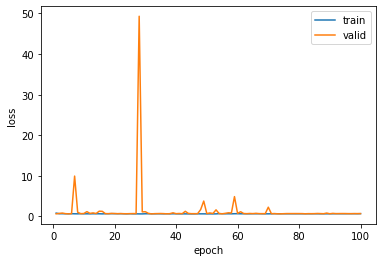

In [16]:
rn_152_trainer.learning_curve()

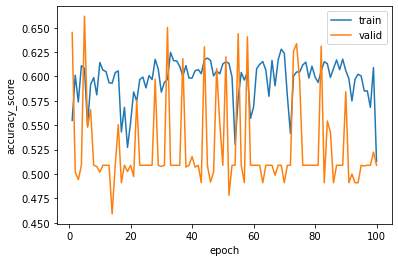

In [17]:
rn_152_trainer.learning_curve(y='accuracy_score')

In [18]:
sort_epochs(rn_152_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
9          0.661765    5.0      0.680787        0.585938      0.734925
63         0.650256   32.0      0.632335        0.687500      0.614322
1          0.645141    1.0      0.655930        0.583333      0.704774
109        0.643862   55.0      0.638270        0.634115      0.653266
115        0.640665   58.0      0.626225        0.665365      0.616834
..              ...    ...           ...             ...           ...
125        0.491049   63.0      0.491049        1.000000      0.000000
85         0.491049   43.0      0.491037        0.998698      0.001256
171        0.491049   86.0      0.491049        1.000000      0.000000
103        0.478261   52.0      0.400000        0.125000      0.819095
27         0.459079   14.0      0.437097        0.352865      0.561558

[100 rows x 5 columns]


# wide resnet 50_2

In [19]:
rn50_2 = models.wide_resnet50_2(pretrained=True)
rn50_2.conv1 = nn.Conv2d(1, rn50_2.conv1.out_channels,
              kernel_size=rn50_2.conv1.kernel_size[0], 
                      stride=rn50_2.conv1.stride[0], 
                      padding=rn50_2.conv1.padding[0])
num_ftrs = rn50_2.fc.in_features
rn50_2.fc = nn.Linear(num_ftrs, 2)

rn50_2.post_forward = post_forward

rn50_2_trainer = trainer(rn50_2, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [20]:
rn50_2_trainer.train(100, lr=0.01, weight_decay=0.4)

Total:   0%|          | 0/787200 [00:00<?, ?it/s]

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  1 15.91s trainloss=0.82438 validloss=0.87951 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  2 15.93s trainloss=0.70491 validloss=0.69767 accuracy_score=0.49105 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  3 15.98s trainloss=0.69021 validloss=0.87006 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  4 16.10s trainloss=0.68899 validloss=27.79208 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  5 16.00s trainloss=0.67495 validloss=0.75773 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  6 16.03s trainloss=0.64909 validloss=0.83973 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  7 16.06s trainloss=0.65232 validloss=0.69290 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  8 16.05s trainloss=0.66071 validloss=0.69971 accuracy_score=0.50895 
  9 16.04s trainloss=0.65947 validloss=0.98331 accuracy_score=0.50639 
 10 16.00s trainloss=0.66567 validloss=0.75378 accuracy_score=0.50767 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 11 15.97s trainloss=0.66433 validloss=0.76714 accuracy_score=0.50895 
 12 15.97s trainloss=0.63868 validloss=0.68839 accuracy_score=0.50831 
 13 15.98s trainloss=0.65304 validloss=9.19451 accuracy_score=0.55946 
 14 15.96s trainloss=0.65801 validloss=0.69786 accuracy_score=0.50831 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 15 15.95s trainloss=0.66433 validloss=0.69512 accuracy_score=0.50895 
 16 15.97s trainloss=0.65999 validloss=0.65896 accuracy_score=0.61189 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 17 15.95s trainloss=0.65416 validloss=0.82970 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 18 15.94s trainloss=0.63642 validloss=0.79277 accuracy_score=0.50895 
 19 15.94s trainloss=0.66361 validloss=0.69853 accuracy_score=0.54284 
 20 15.92s trainloss=0.64924 validloss=0.70022 accuracy_score=0.50831 
 21 15.92s trainloss=0.63986 validloss=2.82134 accuracy_score=0.51023 
 22 15.92s trainloss=0.66687 validloss=0.77400 accuracy_score=0.47123 
 23 15.92s trainloss=0.66227 validloss=0.93228 accuracy_score=0.53453 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 24 15.92s trainloss=0.65333 validloss=0.74287 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 25 15.91s trainloss=0.63517 validloss=0.81808 accuracy_score=0.50895 
 26 15.88s trainloss=0.64505 validloss=0.69339 accuracy_score=0.50959 
 27 15.90s trainloss=0.66057 validloss=0.72737 accuracy_score=0.50320 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 28 15.98s trainloss=0.66171 validloss=0.80021 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 29 15.95s trainloss=0.66586 validloss=0.73693 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 30 15.94s trainloss=0.63864 validloss=0.68899 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 31 15.94s trainloss=0.66832 validloss=0.69869 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 32 15.94s trainloss=0.65297 validloss=0.69449 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 33 15.93s trainloss=0.65735 validloss=0.68431 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 34 15.94s trainloss=0.67371 validloss=0.70199 accuracy_score=0.50895 
 35 15.92s trainloss=0.68394 validloss=0.76377 accuracy_score=0.49361 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 36 15.93s trainloss=0.67821 validloss=0.72667 accuracy_score=0.50895 
 37 15.92s trainloss=0.66777 validloss=0.65795 accuracy_score=0.61061 
 38 15.92s trainloss=0.67128 validloss=0.69178 accuracy_score=0.50639 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 39 15.92s trainloss=0.68424 validloss=0.77463 accuracy_score=0.50895 
 40 15.92s trainloss=0.67573 validloss=0.68906 accuracy_score=0.62084 
 41 15.92s trainloss=0.66717 validloss=1.14585 accuracy_score=0.49680 
 42 15.91s trainloss=0.66633 validloss=0.68488 accuracy_score=0.50000 
 43 15.90s trainloss=0.66713 validloss=0.66312 accuracy_score=0.65729 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 44 15.90s trainloss=0.66184 validloss=1.05161 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 45 15.90s trainloss=0.65722 validloss=0.98819 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 46 15.88s trainloss=0.65714 validloss=0.81233 accuracy_score=0.50895 
 47 15.88s trainloss=0.65220 validloss=0.67519 accuracy_score=0.50000 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 48 15.89s trainloss=0.65731 validloss=0.70398 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 49 15.88s trainloss=0.68264 validloss=0.69605 accuracy_score=0.50895 
 50 15.86s trainloss=0.68301 validloss=0.68748 accuracy_score=0.50895 
 51 15.95s trainloss=0.67190 validloss=0.68661 accuracy_score=0.54028 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 52 15.82s trainloss=0.66338 validloss=0.76034 accuracy_score=0.50895 
 53 15.82s trainloss=0.66041 validloss=0.68476 accuracy_score=0.55371 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 54 15.85s trainloss=0.65483 validloss=0.70701 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 55 15.85s trainloss=0.66085 validloss=0.76627 accuracy_score=0.50895 
 56 15.84s trainloss=0.66022 validloss=0.65370 accuracy_score=0.62404 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 57 15.85s trainloss=0.65964 validloss=0.84272 accuracy_score=0.50895 
 58 15.85s trainloss=0.65659 validloss=0.71672 accuracy_score=0.50959 
 59 15.85s trainloss=0.66564 validloss=0.66794 accuracy_score=0.60678 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 60 15.85s trainloss=0.66394 validloss=0.74474 accuracy_score=0.50895 
 61 15.85s trainloss=0.66433 validloss=0.67099 accuracy_score=0.62404 
 62 15.85s trainloss=0.66426 validloss=0.66801 accuracy_score=0.64834 
 63 15.85s trainloss=0.66108 validloss=0.66318 accuracy_score=0.60870 
 64 15.84s trainloss=0.67392 validloss=0.69180 accuracy_score=0.54476 
 65 15.85s trainloss=0.67607 validloss=0.66862 accuracy_score=0.59974 
 66 15.84s trainloss=0.66972 validloss=0.69912 accuracy_score=0.52621 
 67 15.84s trainloss=0.67263 validloss=0.66786 accuracy_score=0.59591 
 68 15.83s trainloss=0.66947 validloss=0.68841 accuracy_score=0.54987 
 69 15.84s trainloss=0.66637 validloss=0.69585 accuracy_score=0.52813 
 70 15.83s trainloss=0.66372 validloss=0.72512 accuracy_score=0.50512 
 71 15.84s trainloss=0.66425 validloss=0.66012 accuracy_score=0.62724 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 72 15.83s trainloss=0.67796 validloss=0.69083 accuracy_score=0.50895 
 73 15.79s trainloss=0.69091 validloss=0.68759 accuracy_score=0.52685 
 74 15.78s trainloss=0.68721 validloss=0.68372 accuracy_score=0.56138 
 75 15.87s trainloss=0.68558 validloss=0.68258 accuracy_score=0.55946 
 76 15.78s trainloss=0.68480 validloss=0.69326 accuracy_score=0.50064 
 77 15.76s trainloss=0.68307 validloss=0.68048 accuracy_score=0.55818 
 78 15.76s trainloss=0.68442 validloss=0.69089 accuracy_score=0.51662 
 79 15.77s trainloss=0.68597 validloss=0.67863 accuracy_score=0.57033 
 80 15.77s trainloss=0.68690 validloss=0.68176 accuracy_score=0.55115 
 81 15.77s trainloss=0.68616 validloss=0.68311 accuracy_score=0.55499 
 82 15.77s trainloss=0.68528 validloss=0.68167 accuracy_score=0.54348 
 83 15.76s trainloss=0.68675 validloss=0.67773 accuracy_score=0.57609 
 84 15.76s trainloss=0.68686 validloss=0.68138 accuracy_score=0.54028 
 85 15.77s trainloss=0.68609 validloss=0.68187 accuracy_score=0.55179 
 86 15

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 92 15.77s trainloss=0.68541 validloss=0.68682 accuracy_score=0.50895 
 93 15.77s trainloss=0.68646 validloss=0.68333 accuracy_score=0.54220 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 94 15.77s trainloss=0.68599 validloss=0.68783 accuracy_score=0.50895 
 95 15.76s trainloss=0.68555 validloss=0.68404 accuracy_score=0.54220 
 96 15.77s trainloss=0.68510 validloss=0.68343 accuracy_score=0.54220 
 97 15.76s trainloss=0.68560 validloss=0.68315 accuracy_score=0.56010 
 98 15.87s trainloss=0.68601 validloss=0.68206 accuracy_score=0.56650 
 99 15.75s trainloss=0.68694 validloss=0.68987 accuracy_score=0.51407 
100 15.73s trainloss=0.68640 validloss=0.68946 accuracy_score=0.52238 


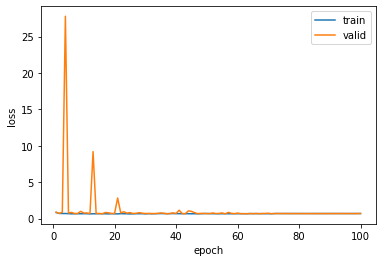

In [21]:
rn50_2_trainer.learning_curve()

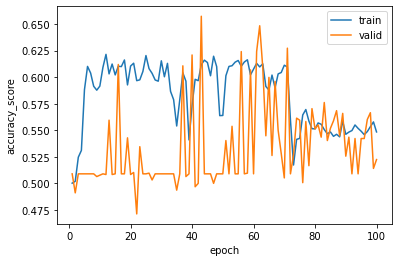

In [22]:
rn50_2_trainer.learning_curve(y='accuracy_score')

In [23]:
sort_epochs(rn50_2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
85         0.657289   43.0      0.677914        0.575521      0.736181
123        0.648338   62.0      0.737991        0.440104      0.849246
141        0.627238   71.0      0.587512        0.808594      0.452261
111        0.624041   56.0      0.591278        0.759115      0.493719
121        0.624041   61.0      0.846154        0.286458      0.949749
..              ...    ...           ...             ...           ...
93         0.500000   47.0      0.418605        0.046875      0.937186
81         0.496803   41.0      0.493891        1.000000      0.011307
69         0.493606   35.0      0.492308        1.000000      0.005025
3          0.491049    2.0      0.491049        1.000000      0.000000
43         0.471228   22.0      0.453834        0.377604      0.561558

[100 rows x 5 columns]


# resnet 50

In [24]:
rn50 = models.resnet50(pretrained=True)
rn50.conv1 = nn.Conv2d(1, rn50.conv1.out_channels,
              kernel_size=rn50.conv1.kernel_size[0], 
                      stride=rn50.conv1.stride[0], 
                      padding=rn50.conv1.padding[0])
num_ftrs = rn50.fc.in_features
rn50.fc = nn.Linear(num_ftrs, 2)

rn50.post_forward = post_forward

rn50_trainer = trainer(rn50, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [25]:
rn50_trainer.train(100, lr=0.01)

Total:   0%|          | 0/787200 [00:00<?, ?it/s]

  1 10.43s trainloss=0.84584 validloss=22.11326 accuracy_score=0.56138 
  2 10.45s trainloss=0.69636 validloss=0.80816 accuracy_score=0.57928 
  3 10.45s trainloss=0.65879 validloss=0.98980 accuracy_score=0.52046 
  4 10.44s trainloss=0.64408 validloss=0.72170 accuracy_score=0.50703 
  5 10.45s trainloss=0.63688 validloss=41.22306 accuracy_score=0.48529 
  6 10.41s trainloss=0.63782 validloss=1.00427 accuracy_score=0.49936 
  7 10.41s trainloss=0.63831 validloss=1.00245 accuracy_score=0.62276 
  8 10.41s trainloss=0.64891 validloss=0.84513 accuracy_score=0.50959 
  9 10.41s trainloss=0.64785 validloss=0.64584 accuracy_score=0.61573 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 10 10.41s trainloss=0.66343 validloss=0.76729 accuracy_score=0.50895 
 11 10.42s trainloss=0.64003 validloss=1.53858 accuracy_score=0.51471 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 12 10.42s trainloss=0.64075 validloss=1.51475 accuracy_score=0.50895 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 13 10.41s trainloss=0.61451 validloss=11.26923 accuracy_score=0.50895 
 14 10.42s trainloss=0.59950 validloss=0.95577 accuracy_score=0.52685 
 15 10.42s trainloss=0.57728 validloss=0.91109 accuracy_score=0.65090 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 16 10.41s trainloss=0.56443 validloss=2.35830 accuracy_score=0.50895 
 17 10.42s trainloss=0.54140 validloss=1.15371 accuracy_score=0.53261 
 18 10.55s trainloss=0.51999 validloss=1.04722 accuracy_score=0.55115 
 19 10.46s trainloss=0.50988 validloss=1.07380 accuracy_score=0.54220 
 20 10.46s trainloss=0.48481 validloss=1.22450 accuracy_score=0.55754 
 21 10.47s trainloss=0.45437 validloss=1.14147 accuracy_score=0.57928 
 22 10.46s trainloss=0.43519 validloss=1.54404 accuracy_score=0.53133 
 23 10.47s trainloss=0.41061 validloss=0.76498 accuracy_score=0.58696 
 24 10.46s trainloss=0.40126 validloss=1.94733 accuracy_score=0.55946 
 25 10.46s trainloss=0.38664 validloss=0.84199 accuracy_score=0.63043 
 26 10.46s trainloss=0.36666 validloss=0.94110 accuracy_score=0.62532 
 27 10.46s trainloss=0.35426 validloss=0.69872 accuracy_score=0.63107 
 28 10.78s trainloss=0.33212 validloss=1.63874 accuracy_score=0.62084 
 29 10.46s trainloss=0.32507 validloss=1.40401 accuracy_score=0.59079 
 30 10

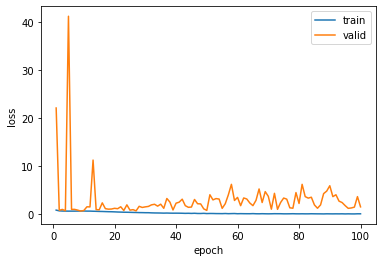

In [26]:
rn50_trainer.learning_curve()

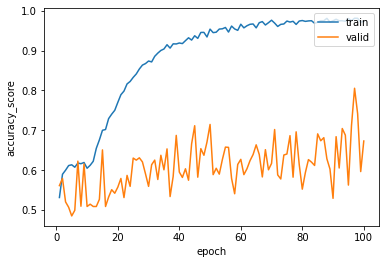

In [27]:
rn50_trainer.learning_curve(y='accuracy_score')

In [28]:
sort_epochs(rn50_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
193        0.805627   97.0      0.747863        0.911458      0.703518
195        0.741688   98.0      0.667587        0.944010      0.546482
99         0.714834   50.0      0.677313        0.800781      0.631910
191        0.711637   96.0      0.651675        0.886719      0.542714
89         0.711637   45.0      0.646623        0.910156      0.520101
..              ...    ...           ...             ...           ...
23         0.508951   12.0      0.000000        0.000000      1.000000
19         0.508951   10.0      0.000000        0.000000      1.000000
7          0.507033    4.0      0.200000        0.001302      0.994975
11         0.499361    6.0      0.485030        0.316406      0.675879
9          0.485294    5.0      0.352000        0.057292      0.898241

[100 rows x 5 columns]


# End notebook

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>